# BNS 4 param example 


# Agenda

1. Carry out Parameter estimation on a binary neutron star system
1. Stochastically sample the posterior distribution using `bilby`.


## Notes
1. BNS signals are longer (by a factor of 10, low masses)
1. More intelligent sampling necessary (nestle)
1. More intelligent likelihood evaluation necessary (relative binning)

## Relative binning
1. Chop up the domain into multiple frequency bins
1. Ecpress the waveform TaylorExpansion away from a fiducial waveform (linear interpolation withing bins)
1. Approximate the likelihood evaluation : simpler, fewer evaluation



# Parameter estimation
1. Inject a BNS singal into a detector
1. Analze using bilby and nestle.

## Fixed parameters

1. Extrinsic
    1. Polarization angle `psi`, 
    1. Sky location `ra`, `dec`,
    1. Signal's arrival time at geocenter `geocent_time`,
    1. Orbital / coalescence `phase`,
    1. Inclination angle `theta_jn`
    1. Luminosity distance `luminosity_distance`
1. Intrinsic
    1. Spin components `a_1`, `a_2`, `tilt_1`, `tilt_2`, `phi_12`, `phi_jl`
    1. Tidal deformabilities `lambda_1`, `lambda_2`

##  To sample over
1. Intrinsic:
    1. Component masses `m_1`, `m_2` in terms of `symmetric_mass_ratio`, `chirp_mass`
    \begin{equation}
     \eta = \dfrac{m_1 m_2}{(m_1 + m_2)^2} \qquad,\,\, \mathcal{M} = \dfrac{(m_1 * m_2)^{3/5}}{(m_1 + m_2)^{1/5}}
    \end{equation}
## Priors
1. Uniform in (component masses)
1. Uniform in comoving volume prior on luminosity distance (100Mpc, 5Gpc)

In [1]:
import bilby
from bilby.core.utils.random import seed

# Sets seed of bilby's generator "rng" to "123" to ensure reproducibility
seed(123)

# Specify the output directory and the name of the simulation.
outdir = "bns_outdir"
label = "bns_2param_rb_5"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

/home/vaishakprasad/soft/anaconda/envs/igwn-py310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Injection parameters

In [2]:

# We are going to inject a binary neutron star waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# aligned spins of both black holes (chi_1, chi_2), etc.
injection_parameters = dict(
    mass_1=1.5,
    mass_2=1.3,
    chi_1=0.02,
    chi_2=0.02,
    luminosity_distance=50.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
    lambda_1=545,
    lambda_2=1346,
    fiducial=1
)


mass_ratio = injection_parameters["mass_2"]/injection_parameters["mass_1"]
chirp_mass = (injection_parameters["mass_1"]*injection_parameters["mass_2"])**(3/5) / (injection_parameters["mass_1"] + injection_parameters["mass_2"] )**(1/5)

In [3]:
chirp_mass

1.2150360414642816

## Data sampling parameters

In [4]:

# Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the
# TaylorF2 waveform, we cut the signal close to the isco frequency
duration = 32
sampling_frequency = 2048
start_time = injection_parameters["geocent_time"] + 2 - duration

# Waveform generator

In [5]:

# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2_NRTidal",
    reference_frequency=50.0,
    minimum_frequency=40.0,
)

# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star_relative_binning,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments,
)

15:09 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star_relative_binning
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


## Inject the signal into the detector

In [6]:

# Set up interferometers.  In this case we'll use three interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1), and Virgo (V1)).
# These default to their design sensitivity and start at 40 Hz.
interferometers = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])
for interferometer in interferometers:
    interferometer.minimum_frequency = 40
interferometers.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration, start_time=start_time
)
interferometers.inject_signal(
    parameters=injection_parameters, waveform_generator=waveform_generator
)

/home/vaishakprasad/soft/anaconda/envs/igwn-py310/lib/python3.10/site-packages/bilby/gw/source.py:528: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
15:09 bilby INFO    : Injected signal in H1:
15:09 bilby INFO    :   optimal SNR = 34.44
15:09 bilby INFO    :   matched filter SNR = 33.89-0.55j
15:09 bilby INFO    :   mass_1 = 1.5
15:09 bilby INFO    :   mass_2 = 1.3
15:09 bilby INFO    :   chi_1 = 0.02
15:09 bilby INFO    :   chi_2 = 0.02
15:09 bilby INFO    :  

[{'plus': array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -4.23008636e-25+7.98210938e-26j, -4.23011798e-25+7.97089719e-26j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         7.95519924e-26+4.21582544e-25j, 7.94402485e-26+4.21585695e-25j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -4.23008636e-25+7.98210938e-26j, -4.23011798e-25+7.97089719e-26j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         7.95519924e-26+4.21582544e-25j, 7.94402485e-26+4.21585695e-25j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': ar

## Define the priors

In [7]:
chirp_mass

1.2150360414642816

In [8]:
mass_ratio

0.8666666666666667

In [9]:

# Load the default prior for binary neutron stars.
# We're going to sample in chirp_mass, symmetric_mass_ratio, lambda_tilde, and
# delta_lambda_tilde rather than mass_1, mass_2, lambda_1, and lambda_2.
# BNS have aligned spins by default, if you want to allow precessing spins
# pass aligned_spin=False to the BNSPriorDict
priors = bilby.gw.prior.BNSPriorDict()
for key in [
    "psi",
    "geocent_time",
    "ra",
    "dec",
    "chi_1",
    "chi_2",
    "theta_jn",
    "luminosity_distance",
    "phase",
    "lambda_1",
    'lambda_2'
]:
    priors[key] = injection_parameters[key]

# Reparametrize in terms of symmetric mass ratio and chirp mass
#del priors["mass_ratio"], priors["lambda_1"], priors["lambda_2"]
priors['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(minimum=0.9, maximum=1.3, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
priors['mass_ratio'] = bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.6, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
#priors["mass_ratio"] = mass_ratio
#del priors["lambda_1"], priors["lambda_2"]

#priors["chirp_mass"] = bilby.core.prior.Gaussian(
#    1.215, 0.1, name="chirp_mass", unit="$M_{\\odot}$"
#)
#priors["symmetric_mass_ratio"] = bilby.core.prior.Uniform(
#    0.1, 0.25, name="symmetric_mass_ratio"
#)

15:09 bilby INFO    : No prior given, using default BNS priors in /home/vaishakprasad/soft/anaconda/envs/igwn-py310/lib/python3.10/site-packages/bilby/gw/prior_files/aligned_spins_bns_tides_on.prior.


In [10]:
priors

{'mass_1': Constraint(minimum=0.5, maximum=5, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=0.5, maximum=5, name='mass_2', latex_label='$m_2$', unit=None),
 'mass_ratio': bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.6, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False),
 'chirp_mass': bilby.gw.prior.UniformInComponentsChirpMass(minimum=0.9, maximum=1.3, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'luminosity_distance': 50.0,
 'dec': -1.2108,
 'ra': 1.375,
 'theta_jn': 0.4,
 'psi': 2.659,
 'phase': 1.3,
 'chi_1': 0.02,
 'chi_2': 0.02,
 'lambda_1': 545,
 'lambda_2': 1346,
 'geocent_time': 1126259642.413}

## Initialize the likelihood

In [11]:
# Initialise the likelihood by passing in the interferometer data (IFOs)
# and the waveform generator
likelihood = bilby.gw.likelihood.RelativeBinningGravitationalWaveTransient(
    interferometers=interferometers,
    waveform_generator=waveform_generator,
    priors=priors,
    distance_marginalization=False,
    fiducial_parameters=injection_parameters.copy()
)

# Run sampler.  In this case we're going to use the `nestle` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="nestle",
    npoints=100,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
    result_class=bilby.gw.result.CBCResult,
    #bound='multi'
)

15:09 bilby INFO    : Initial fiducial waveforms set up
15:09 bilby INFO    : Summary Data Obtained
15:09 bilby INFO    : Fiducial likelihood: 1411.25
15:09 bilby INFO    : Running for label 'bns_2param_rb_5', output will be saved to 'bns_outdir'
15:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
15:09 bilby WARNING : Parameter fiducial has no default prior and is set to 0, this will not be sampled and may cause an error.
15:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
15:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
15:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
15:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
15:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
15:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test

it=  1426 logz=1398.7107533


15:10 bilby INFO    : Sampling time: 0:01:10.519334
15:10 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/1527 [00:00<?, ?it/s]

15:10 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/1527 [00:00<?, ?it/s]

15:10 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/1527 [00:00<?, ?it/s]

15:10 bilby INFO    : Summary of results:
nsamples: 1527
ln_noise_evidence: -95975.554
ln_evidence: -94576.425 +/-  0.352
ln_bayes_factor: 1399.129 +/-  0.352



In [12]:
all_injection_parameters = bilby.gw.conversion.generate_all_bns_parameters(injection_parameters)

In [13]:
result.posterior

,chirp_mass,mass_ratio,luminosity_distance,dec,ra,theta_jn,psi,phase,chi_1,chi_2,...,chi_2_in_plane,chi_p,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,lambda_tilde,delta_lambda_tilde
0,1.215013,0.866667,50.0,-1.2108,1.375,0.4,2.659,1.3,0.02,0.02,...,0.0,0.0,0.011202,49.446114,1.483355,1.285574,1.201553,2.768929,867.993156,95.051301
1,1.215015,0.866667,50.0,-1.2108,1.375,0.4,2.659,1.3,0.02,0.02,...,0.0,0.0,0.011202,49.446114,1.483357,1.285576,1.201555,2.768933,867.993156,95.051301
2,1.215016,0.866667,50.0,-1.2108,1.375,0.4,2.659,1.3,0.02,0.02,...,0.0,0.0,0.011202,49.446114,1.483359,1.285577,1.201556,2.768936,867.993156,95.051301
3,1.215067,0.866667,50.0,-1.2108,1.375,0.4,2.659,1.3,0.02,0.02,...,0.0,0.0,0.011202,49.446114,1.483421,1.285632,1.201607,2.769053,867.993156,95.051301
4,1.215017,0.866667,50.0,-1.2108,1.375,0.4,2.659,1.3,0.02,0.02,...,0.0,0.0,0.011202,49.446114,1.483361,1.285579,1.201558,2.768940,867.993156,95.051301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,1.215041,0.866667,50.0,-1.2108,1.375,0.4,2.659,1.3,0.02,0.02,...,0.0,0.0,0.011202,49.446114,1.483389,1.285604,1.201581,2.768993,867.993156,95.051301
1221,1.215041,0.866667,50.0,-1.2108,1.375,0.4,2.659,1.3,0.02,0.02,...,0.0,0.0,0.011202,49.446114,1.483389,1.285604,1.201581,2.768993,867.993156,95.051301
1222,1.215041,0.866667,50.0,-1.2108,1.375,0.4,2.659,1.3,0.02,0.02,...,0.0,0.0,0.011202,49.446114,1.483389,1.285604,1.201581,2.768993,867.993156,95.051301
1223,1.215041,0.866667,50.0,-1.2108,1.375,0.4,2.659,1.3,0.02,0.02,...,0.0,0.0,0.011202,49.446114,1.483389,1.285604,1.201581,2.768993,867.993156,95.051301


In [14]:
truths = {}

#for key in ["chirp_mass", "symmetric_mass_ratio"]:
for key in ["chirp_mass"]:
    truths.update({key : all_injection_parameters[key]})

In [15]:
truths

{'chirp_mass': 1.2150360414642816}

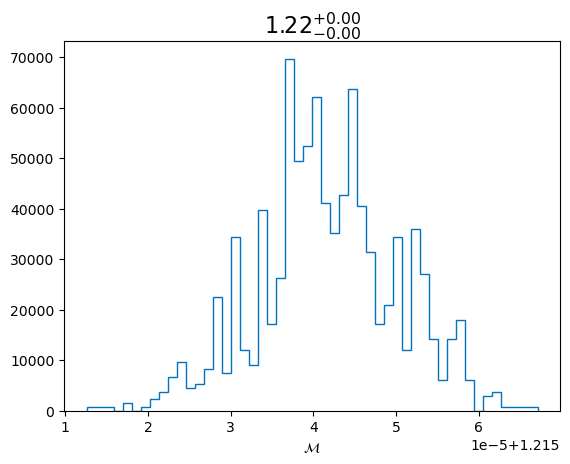

In [16]:
result.plot_corner(truths=truths)

In [25]:
truths

{'chirp_mass': 1.2150360414642816}